In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import glob
from redshift_utils import *
from default_globals import *
import astropy.units as u
from scipy.integrate import romb
from scipy.interpolate import interp1d


# Load the target population

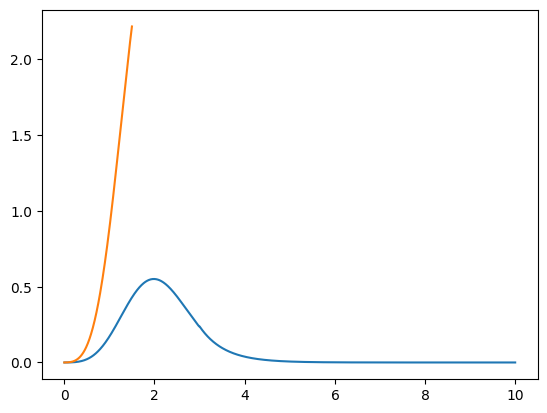

In [3]:
GW_ZMIN = 1e-4
GW_ZMAX = 1.5
Z_INTEGRAL_AX = np.linspace(1e-4, GW_ZMAX, 1024+1)
dz = np.diff(Z_INTEGRAL_AX)[0]

qlf = 'kulkarni'
thresh = '45.0'
agn_zprior = f'/agn_redshift_pdf_{thresh}_{qlf}.npy'
agn_dist_dir = '/home/lucas/Documents/PhD/darksirenpop/agn_distribution'
agn_zprior_path = f'{agn_dist_dir}{agn_zprior}'

redshift_array, target_population_full = np.load(agn_zprior_path)
target_population_interp = interp1d(redshift_array, target_population_full, bounds_error=False, fill_value=0)
norm = romb(target_population_interp(Z_INTEGRAL_AX), dx=dz)
target_population = lambda z: target_population_interp(z) / norm

plt.figure()
plt.plot(redshift_array, target_population_full)
plt.plot(Z_INTEGRAL_AX, target_population(Z_INTEGRAL_AX))
plt.show()


# Load the GW coordinates

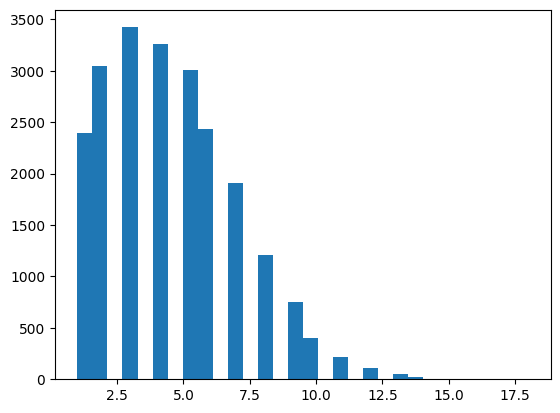

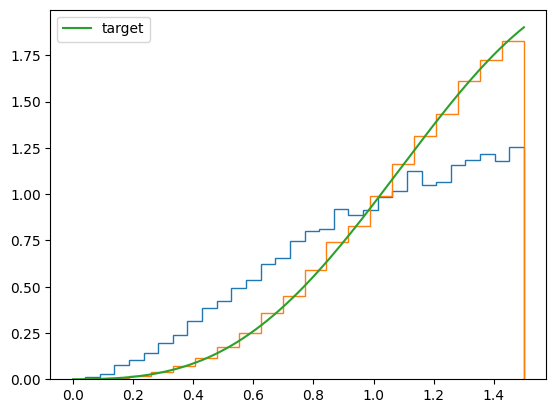

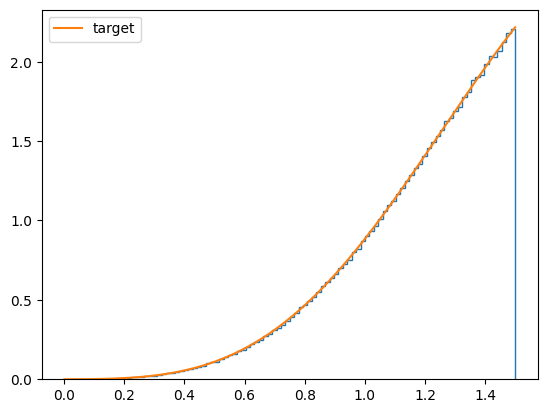

In [ ]:
SKYMAP_DIR = f"/home/lucas/Documents/PhD/skymaps_all/"

N_REALIZATIONS = 1
BATCH = int(1e5) #len(np.array(glob.glob('/home/lucas/Documents/PhD/mockstats/' + 'gw*.dat'))) 
TRUE_FAGNS = np.tile(0.5, N_REALIZATIONS)
REALIZED_FAGNS = np.random.binomial(BATCH, TRUE_FAGNS) / BATCH  # Observed f_agn fluctuates around the true value
N_TRUE_FAGNS = len(TRUE_FAGNS)

CORRECT_TIME_DILATION = True


all_gw_fnames = np.array(glob.glob(SKYMAP_DIR + 'skymap_*'))
ALL_TRUE_SOURCES = np.genfromtxt('/home/lucas/Documents/PhD/true_r_theta_phi_all.txt', delimiter=',')
ALL_TRUE_SOURCES = ALL_TRUE_SOURCES[ALL_TRUE_SOURCES[:, 0].argsort()]
TRUE_SOURCE_IDENTIFIERS = ALL_TRUE_SOURCES[:,0]

agn_ra, agn_dec, agn_rcom = ALL_TRUE_SOURCES[:,3], 0.5 * np.pi - ALL_TRUE_SOURCES[:,2], ALL_TRUE_SOURCES[:,1]
agn_z = fast_z_at_value(COSMO.comoving_distance, agn_rcom * u.Mpc)

# plt.figure()
# plt.hist(agn_ra, density=True, bins=30)
# plt.show()

# plt.figure()
# plt.hist(agn_dec, density=True, bins=30)
# plt.show()

weights = target_population(agn_z) / uniform_comoving_prior(agn_z)
if CORRECT_TIME_DILATION:
    weights *= 1 / (1 + agn_z)
from_agn_population = np.random.choice(np.arange(len(agn_z)), p=weights / np.sum(weights), size=(BATCH, N_TRUE_FAGNS))
_, counts = np.unique(from_agn_population, return_counts=True)

plt.figure()
plt.hist(counts, bins=30)
plt.show()

weights = merger_rate(agn_z, MERGER_RATE_EVOLUTION, **MERGER_RATE_KWARGS)
if CORRECT_TIME_DILATION:
    weights *= 1 / (1 + agn_z)
from_alt_population = np.random.choice(np.arange(len(agn_z)), p=weights / np.sum(weights), size=BATCH - gw_fnames_from_agn.shape[0])


plt.figure()
plt.hist(agn_z, density=True, bins=30, histtype='step')
plt.hist(agn_z[from_agn_population], density=True, bins=20, histtype='step')
plt.plot(Z_INTEGRAL_AX, target_population(Z_INTEGRAL_AX) / (1 + Z_INTEGRAL_AX) / romb(target_population(Z_INTEGRAL_AX) / (1 + Z_INTEGRAL_AX), dx=dz), label='target')
plt.legend()
plt.show()


cdf = np.cumsum(target_population(Z_INTEGRAL_AX))
cdf /= cdf[-1]
unif = np.random.rand(int(1e6))
agn_catalog = np.interp(unif, cdf, Z_INTEGRAL_AX)

plt.figure()
plt.hist(agn_catalog, density=True, bins=100, histtype='step')
plt.plot(Z_INTEGRAL_AX, target_population(Z_INTEGRAL_AX), label='target')
plt.legend()
plt.show()


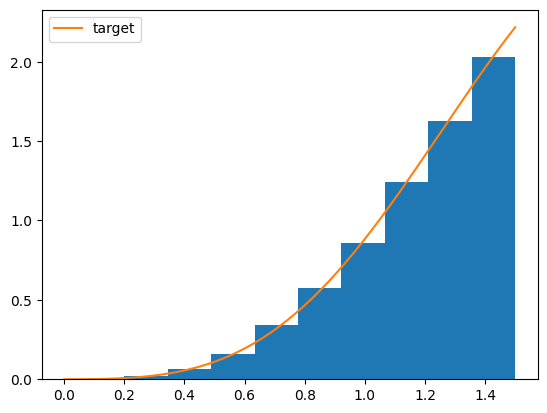

In [60]:
fagn_idx = 0
fagn_true = 1

need_these = TRUE_SOURCE_IDENTIFIERS[from_agn_population].astype(int)
gw_fnames_per_realization = []
for i, row in enumerate(need_these):
    line = []
    for j, id in enumerate(row):
        s = f'{SKYMAP_DIR}/skymap_0_0_{id:05d}.fits.gz'
        line.append(s)
    gw_fnames_per_realization.append(line)
gw_fnames_per_realization = np.array(gw_fnames_per_realization)


### Get true source coordinates for GWs from AGN to put in the AGN catalog ###
gw_fnames = gw_fnames_per_realization[:,fagn_idx]
gw_fnames_from_agn = gw_fnames[:round(fagn_true * BATCH)]
gw_identifiers = sorted(np.array([f[-13:-8] for f in gw_fnames_from_agn]).astype(int))
true_sources = ALL_TRUE_SOURCES[np.searchsorted(TRUE_SOURCE_IDENTIFIERS, gw_identifiers)]
agn_ra, agn_dec, agn_rcom = true_sources[:,3], 0.5 * np.pi - true_sources[:,2], true_sources[:,1]

plt.figure()
plt.hist(fast_z_at_value(COSMO.comoving_distance, agn_rcom * u.Mpc), density=True)
plt.plot(Z_INTEGRAL_AX, target_population(Z_INTEGRAL_AX), label='target')
plt.legend()
plt.show()
